## ICDAR 2015 exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from os import listdir
from os.path import isfile, join
import random
import numpy as np

%matplotlib inline

### Load data

In [2]:
imgs_dir = r"../icdar2015/ch4_test_images"
labels_dir = r"../icdar2015/Challenge4_Test_Task4_GT"

In [3]:
labels_files = [f for f in listdir(labels_dir) if isfile(join(labels_dir, f))]
print(f"labels files count: {len(labels_files)}")

labels files count: 500


In [4]:
images_files= [f for f in listdir(imgs_dir) if isfile(join(imgs_dir, f))]
print(f"images files count: {len(images_files)}")
print(f"First 3 images files: {images_files[:3]}")

images files count: 500
First 3 images files: ['img_329.jpg', 'img_473.jpg', 'img_315.jpg']


### Plot random images

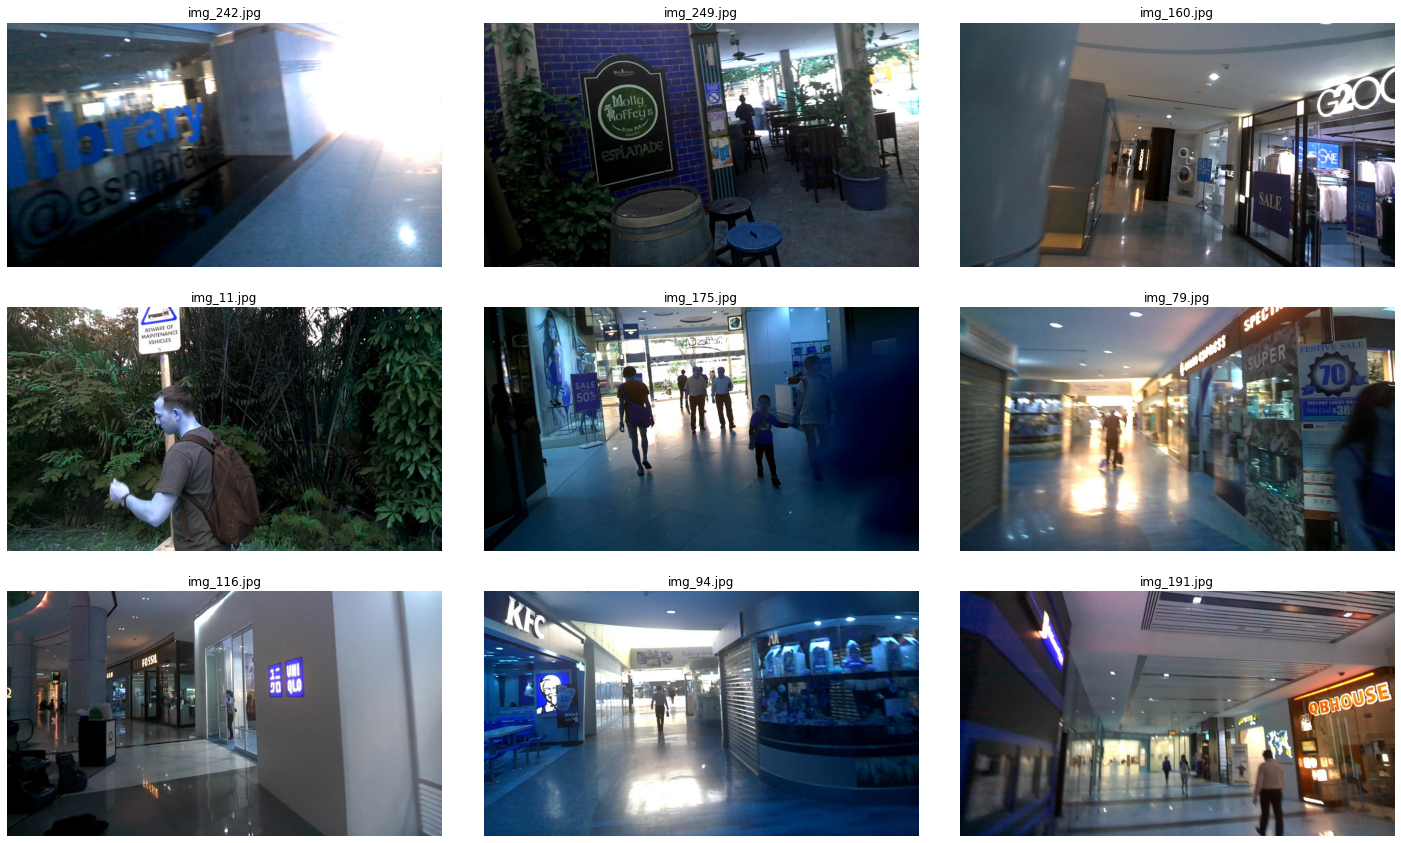

In [5]:
images_to_plot = random.sample(images_files, 9)

fig, axs = plt.subplots(3, 3, figsize=(20, 12))
plt.tight_layout()
axs = axs.flatten()
for img_name, ax in zip(images_to_plot, axs):
    
    img = cv2.imread(os.path.join(imgs_dir, img_name))
    ax.imshow(img)
    ax.set_title(img_name)
    ax.axis('off')

plt.show()

### Plot image with annotations

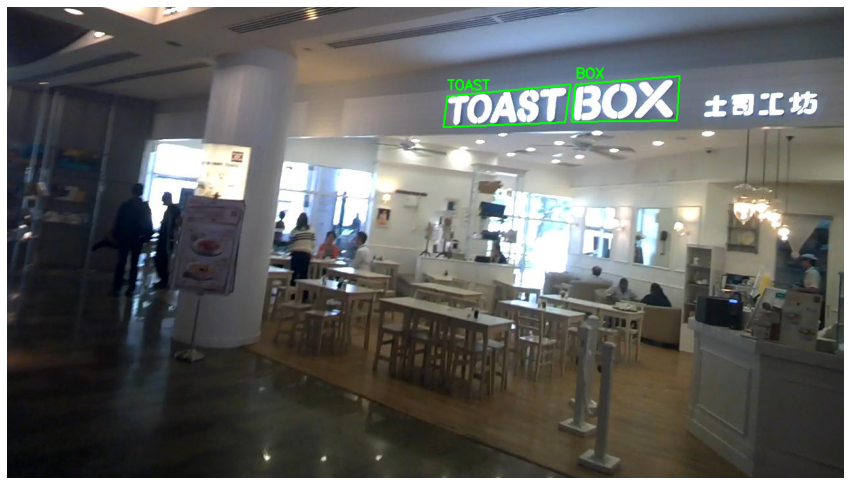

In [6]:
image_number = 245

# Transofrm bounding box annotations
with open(os.path.join(labels_dir, f'gt_img_{image_number}.txt'), encoding='utf-8-sig') as f:
    annotations = f.read().splitlines()
annots = []
for annot in annotations:
    annot = annot.split(',')
    annot_dict = {}
    annot_dict['label'] = annot[-1]
    points = []
    for i, pos in zip(range(4), range(0, 9, 2)):
        points.append([int(annot[pos]), int(annot[pos+1])])
    annot_dict['points'] = np.array(points).reshape((-1,1,2))
    annots.append(annot_dict)

# Plot image with annotations
fig, ax = plt.subplots( figsize=(15, 15))
img = cv2.imread(os.path.join(imgs_dir, f'img_{image_number}.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
for text in annots:
    if text['label'] != "###":
        color = (0, 255, 0)
    else:
        color = (255, 0, 0)
    cv2.polylines(img,[text['points']],True,color, 2)
    cv2.putText(img, text['label'], (text['points'][0][0][0], text['points'][0][0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
ax.axis('off')
ax.imshow(img);

In [16]:
img.shape

(720, 1280, 3)

### Calculate dataset statistics

In [8]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [9]:
dataset_stats = {}

for file in labels_files:
    with open(os.path.join(labels_dir, file), encoding='utf-8-sig') as f:
        dataset_stats[file] = {}
        annotations = f.read().splitlines()
        dataset_stats[file]['annots_number'] = len(annotations)
        
        for i, annot in enumerate(annotations):
            annot = annot.split(',')
            dataset_stats[file][i] = {}
            dataset_stats[file][i]['text'] = annot[-1] if annot[-1] != '###' else ""
            dataset_stats[file][i]['text_len'] = len(annot[-1]) if annot[-1] != '###' else -1
            dataset_stats[file][i]['x'] = np.array([int(annot[pos]) for pos in range(0, 7, 2)])
  
            dataset_stats[file][i]['y'] = np.array([int(annot[pos + 1]) for pos in range(0, 7, 2)])

            dataset_stats[file][i]['area'] = PolyArea(dataset_stats[file][i]['x'], dataset_stats[file][i]['y'])
            dataset_stats[file][i]['width'] = dataset_stats[file][i]['x'].max() - dataset_stats[file][i]['x'].min()
            dataset_stats[file][i]['hight'] = dataset_stats[file][i]['y'].max() - dataset_stats[file][i]['y'].min()  

In [10]:
dataset_stats[f'gt_img_{image_number}.txt']

{'annots_number': 2,
 0: {'text': 'TOAST',
  'text_len': 5,
  'x': array([673, 861, 853, 667]),
  'y': array([136, 118, 176, 183]),
  'area': 9730.0,
  'width': 194,
  'hight': 65},
 1: {'text': 'BOX',
  'text_len': 3,
  'x': array([ 869, 1028, 1024,  863]),
  'y': array([118, 105, 173, 175]),
  'area': 9962.5,
  'width': 165,
  'hight': 70}}

### Annotations count distribution

In [11]:
instance_without_annotation = [stats['text_len'] for image in dataset_stats.values() for stats in image.values() 
                               if isinstance(stats, dict) and stats['text'] == ""]
instances_all = [stats['text_len'] for image in dataset_stats.values() for stats in image.values() 
                               if isinstance(stats, dict)]
print(f"There are {len(instances_all)} text instances in total.")
print(f"{len(instance_without_annotation)} of them don't have annotation.")

There are 5230 text instances in total.
3156 of them don't have annotation.


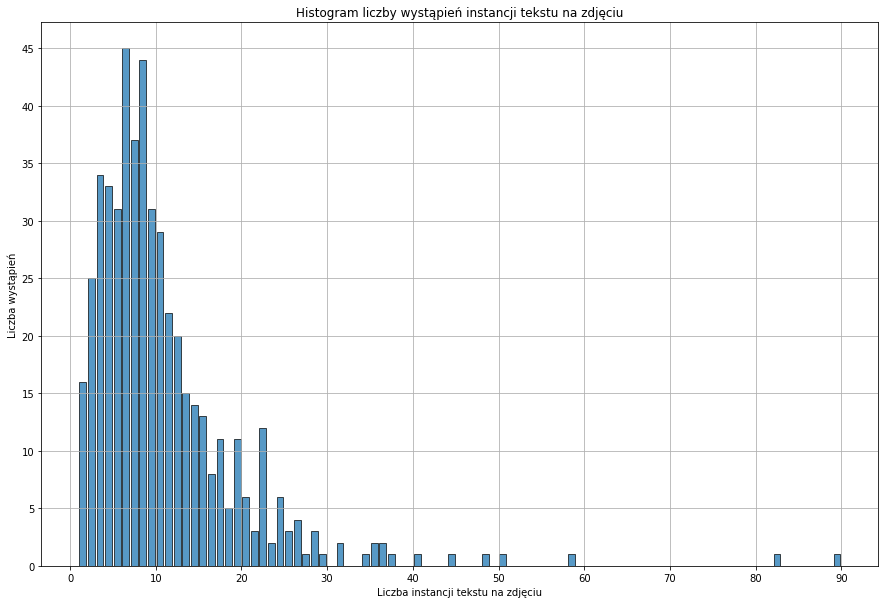

In [12]:
fig, ax = plt.subplots( figsize=(15, 10))

annotation_count = [stats['annots_number'] for stats in dataset_stats.values()]
sns.histplot(annotation_count, ax=ax, binwidth=1, shrink=.8)
# ax.hist(annotation_count, bins=100);
ax.set_xlabel("Liczba instancji tekstu na zdjęciu")
ax.set_ylabel("Liczba wystąpień")
ax.set_title("Histogram liczby wystąpień instancji tekstu na zdjęciu")
ax.set_xticks(np.arange(0, 100, 10))
ax.set_yticks(np.arange(0, 50, 5))
ax.grid()

### Text instances length distribution

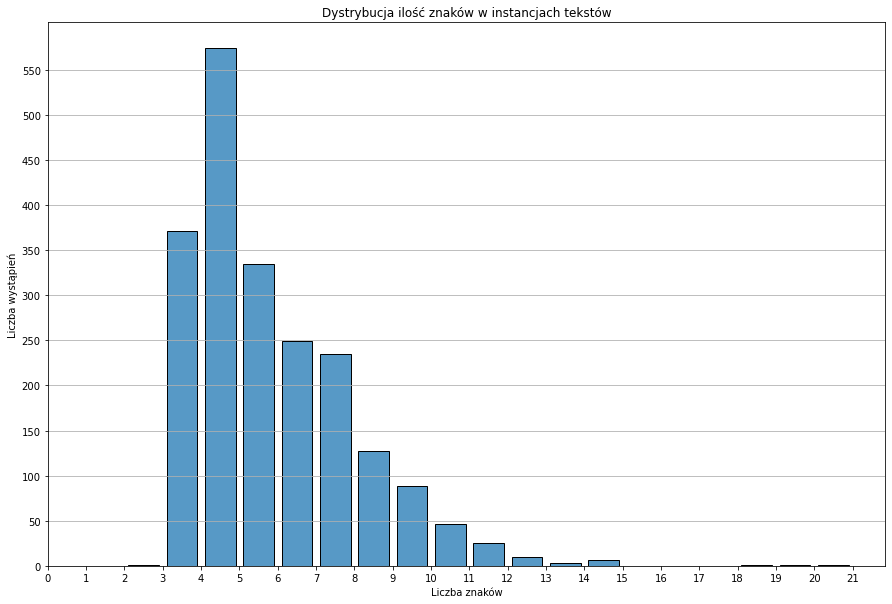

In [13]:
fig, ax = plt.subplots( figsize=(15, 10))

text_length = [stats['text_len'] for image in dataset_stats.values() for stats in image.values() 
               if isinstance(stats, dict) and stats['text'] != ""]

sns.histplot(text_length, ax=ax, binwidth=1, shrink=.8)

ax.set_xlabel("Liczba znaków")
ax.set_ylabel("Liczba wystąpień")
ax.set_title("Dystrybucja ilość znaków w instancjach tekstów")
ax.set_xticks(np.arange(0, 22, 1))
ax.set_yticks(np.arange(0, 600, 50))
ax.grid(axis='y');

### Text instances width and hight

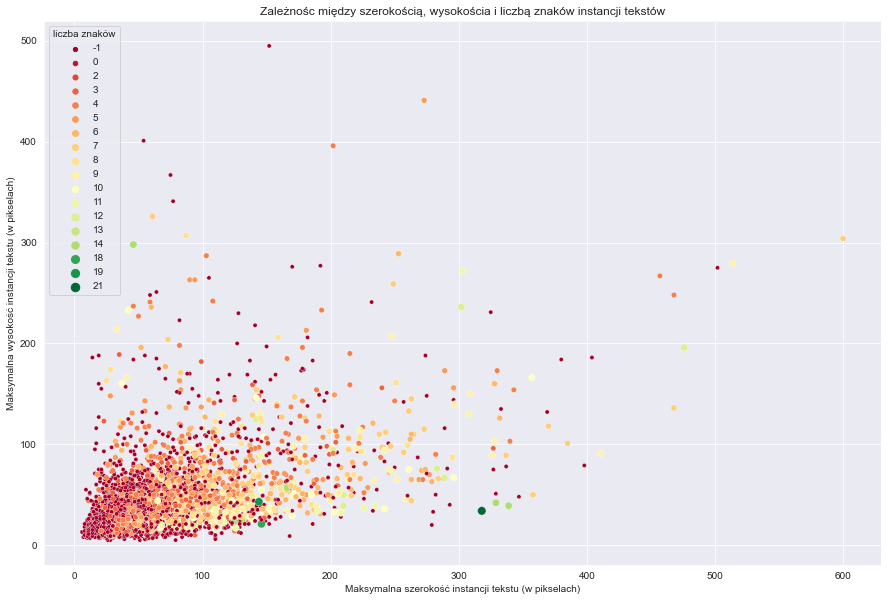

In [14]:
sns.set_style('dark')
fig, ax = plt.subplots( figsize=(15, 10))

text_length = []
text_width = []
text_hight = []

for image in dataset_stats.values():
    for stats in image.values():
        if isinstance(stats, dict):
            text_length.append(stats['text_len'])
            text_width.append(stats['width'])
            text_hight.append(stats['hight'])

df = pd.DataFrame.from_dict({
    'szerokosc': text_width,
    'wysokosc': text_hight,
    'liczba znaków': text_length,
})

sns.scatterplot(x='szerokosc', y='wysokosc', hue='liczba znaków', size='liczba znaków',data=df, palette="RdYlGn", legend='full')

ax.set_xlabel("Maksymalna szerokość instancji tekstu (w pikselach)")
ax.set_ylabel("Maksymalna wysokość instancji tekstu (w pikselach)")

ax.set_title("Zależnośc między szerokością, wysokościa i liczbą znaków instancji tekstów")
ax.grid();


In [15]:
# Save basic ICDAR2015 stats
df.to_csv("ICDAR_2015_stats.csv", index=False)